# Examination signal plots
Code for plotting signal from all the examination phases of one participant.
Files in the dataset contain values from separate study phases and may include delays caused by application errors.
It means, that these files are continuous data for whole examinations.

Some data files in the dataset are missing, due to device problems.
The `data_completeness.csv` file, included in the dataset, contains information about these files.

To make the plot interactive remove the "png" argument from the `fig.show()` command.
If there are problems with displaying plots add the argument:
```
fig.show(renderer="browser")
```

## Setup


In [1]:
import configparser
import os


config = configparser.ConfigParser()
config.read("config.ini")

if not os.path.exists(config['DataDirectories']['unzipped_dataset']):
    raise Exception("Please set path for unzipped dataset in config.ini")

dataset_path = config['DataDirectories']['unzipped_dataset']

## Plot the data

Set a list of participants, a device, and a signal to generate a plot.
Note that the first participant ID is 22, and the last is 64.
Dotted lines represent transitions between phases of the examination.

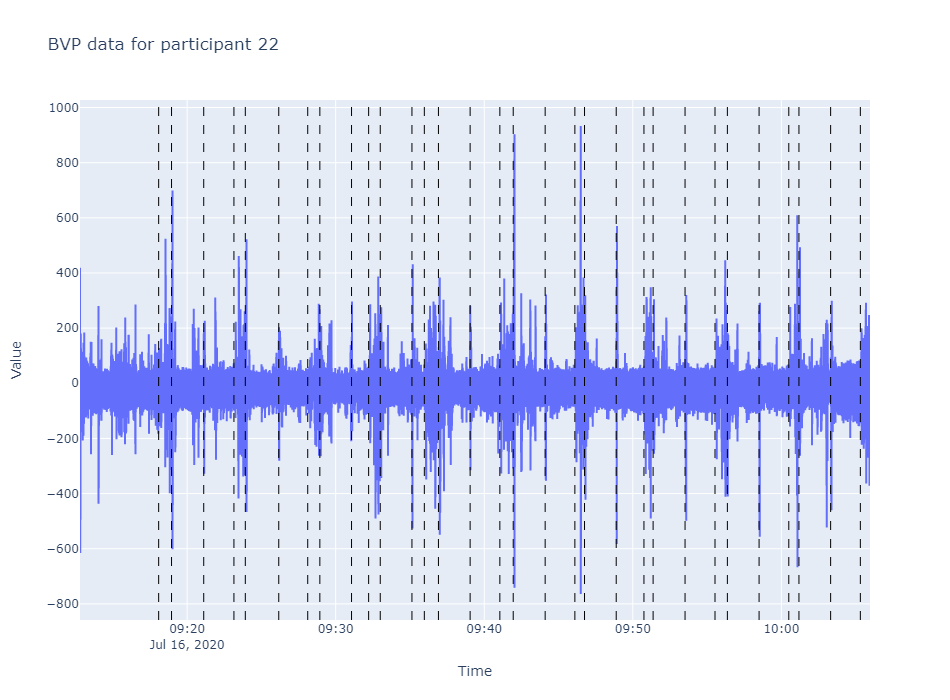

In [2]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from datetime import datetime
from helpers import load_json_file, BASELINE_PHASES, STUDY_PHASES, DATETIME_FORMAT, PARTICIPANTS_ID

 
def plot_signal(signal_data, label, time_lines=None, save_path='./'):
    fig = go.Figure(data=go.Scatter(x=[datetime.strptime(x[0], DATETIME_FORMAT) for x in signal_data],
                                    y=[x[1] for x in signal_data],))
    
    fig.update_layout(height=700, width=950,
                      title=f"{label[0]} data for participant {label[1]}",
                      xaxis_title="Time", yaxis_title="Value",
                      showlegend=False,)
    
    if time_lines is not None:
        for time_line in time_lines[1:]:
            fig.add_vline(x=time_line.timestamp() * 1000, line_width=1,
                          line_dash="dash",
                          line_color="black",)
    
    # to make the plot interactive remove the "png" argument
    fig.show("png")


def plot_signal_for_participants(participants=PARTICIPANTS_ID, device='EMPATICA', signal='BVP'):
    for p_id in participants:
        signal_data, time_lines = [], []
        p_data = load_json_file(
            f'{dataset_path}/{p_id}/{p_id}_QUESTIONNAIRES.json')

        for movie in p_data['metadata']['movie_order']:
            if movie == 'BASELINE':
                phases = BASELINE_PHASES
            else:
                phases = STUDY_PHASES

            for study_phase in phases:
                try:
                    phase_data = load_json_file(f'{dataset_path}/{p_id}/{p_id}_{movie}_{study_phase}_{device}.json')
                    signal_data += phase_data[signal]
                    time_lines.append(datetime.strptime(phase_data[signal][0][0], DATETIME_FORMAT))
                except FileNotFoundError:
                    print(f'There is no file:\n'
                          f'{p_id}_{movie}_{study_phase}_{device}.json')
                    print('Check data_completness.csv file for information about missing files\n')
        plot_signal(signal_data, label=(signal, p_id), time_lines=time_lines)

# avaiable devices with example data to plot
device_signal = {
    'EMPATICA': 'BVP',
    'SAMSUNG_WATCH': 'lightIntesity',
    'MUSE': 'RAW_AF7'
}

# all participants could be presented using PARTICIPANTS_ID variable
plot_signal_for_participants(participants=[22], device='EMPATICA', signal='BVP')

## Samsung Watch BVP processing

Samsung Watch data contains raw and processed BVP signals.
These methods were used on entire sessions (before splitting to study phases).
Details can be found in the article.

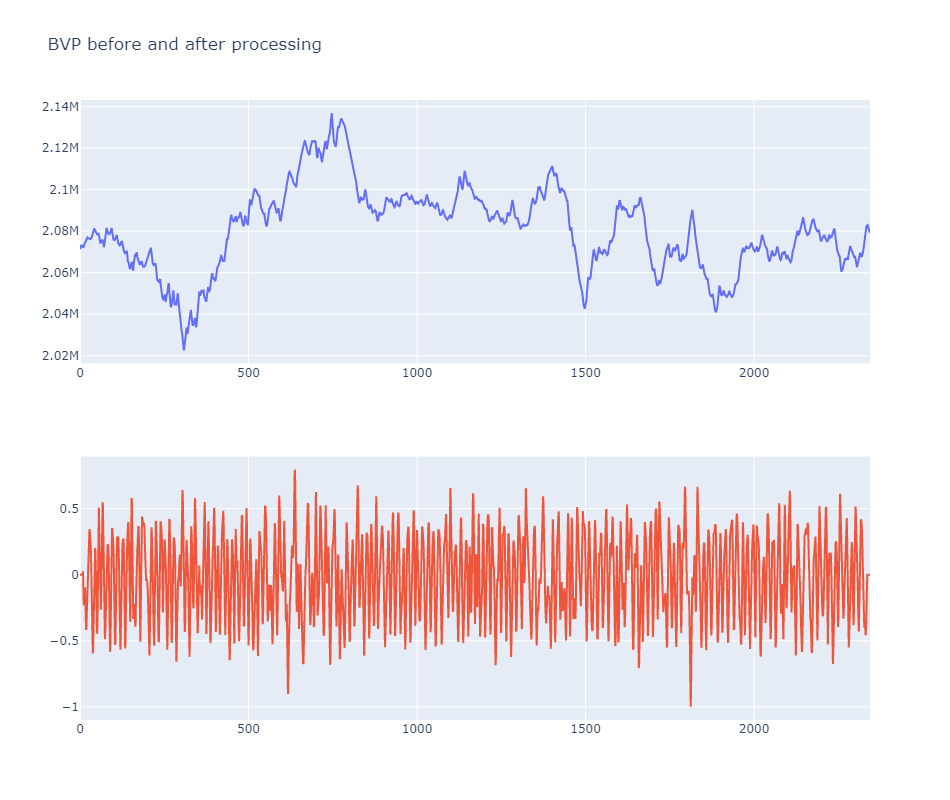

In [3]:
import pandas as pd
import numpy as np
import pywt


def adapt_std(signal: [], freq: int, window_length: int) -> []:
    n = round(freq * window_length)

    if n % 2 == 0:
        n = n + 1

    signal_std = []

    for i in range(len(signal)):

        lower_bound = int(i - np.floor(n/2))
        upper_bound = int(i + np.floor(n/2)+1)
        if lower_bound < 0:
            lower_bound = 0
        if upper_bound > len(signal):
            upper_bound = len(signal)
        window = signal[lower_bound:upper_bound]
        s = np.std(window)
        signal_std.append(signal[i] / s)

    return signal_std


def process_bvp(hrm_raw_signal):
    level = 8

    # the padding is needed as the signal for swt needs to have length that is the multiplicity of the level value
    # here the padding adds 0s to the beginning of the signal
    padded = np.pad(hrm_raw_signal["BVPRaw"], (2 ** level - (len(hrm_raw_signal["BVPRaw"]) % 2 ** level), 0),
                    mode="edge")
    mean_signal = padded - np.mean(padded)

    # wavelet transformation
    swt_coeffs = pywt.swt(mean_signal, 'coif1', level=level, norm=True, trim_approx=True)

    # inverse wavelet transformation using only 2nd and 3rd level
    # indices are different due to return values from the swt function
    iswt_signal = pywt.iswt([swt_coeffs[6], swt_coeffs[5]], 'coif1')
    iswt_signal = iswt_signal[2 ** level - (len(hrm_raw_signal["BVPRaw"]) % 2 ** level):]
    
    # adaptive std
    adapt_std_signal = adapt_std(iswt_signal, 20, 1)
    
    # signal normalization
    norm_signal = adapt_std_signal / np.max(np.abs(adapt_std_signal))

    return norm_signal


def compare_bvp(samsung_data):
    fig = make_subplots(rows=2, cols=1)

    fig.append_trace(go.Scatter(
        x=samsung_data.index,
        y=samsung_data['BVPRaw'],
    ), row=1, col=1)

    fig.append_trace(go.Scatter(
        x=samsung_data.index,
        y=samsung_data['BVPProcessed'],
    ), row=2, col=1)

    fig.update_layout(height=800, width=950,
                      title_text="BVP before and after processing",
                      xaxis_title="Sample", yaxis_title="Value",
                      showlegend=False,)
    
    # to make the plot interactive remove the "png" argument
    fig.show("png")
    

# load data from one phase
p_id, movie, study_phase = 22, "AWE", "STIMULUS"
samsung_data = load_json_file(f'{dataset_path}/{p_id}/{p_id}_{movie}_{study_phase}_SAMSUNG_WATCH.json')


# transforming BVP
bvp_df = pd.DataFrame(samsung_data['BVPRaw'], columns=["TimeStamp", "BVPRaw"])
bvp_df["BVPProcessed"] = process_bvp(bvp_df)

compare_bvp(bvp_df)